# Lab: RNNs for Sentiment Analysis


------------------------------------------------------

*Pablo M. Olmos pamartin@ing.uc3m.es*


------------------------------------------------------

In this notebook we will deploy RNNs to perform sentiment analysis in a real dataset of finantial news. The required preprocesing using standard NLP libraries will be given to you (you have a course on NLP in the second term to learn this part) and your goal will be to define the RNN model, train it and validate the results.


We will use the [Finantial Phrase Bank](https://www.researchgate.net/profile/Pekka-Malo/publication/251231364_FinancialPhraseBank-v10/data/0c96051eee4fb1d56e000000/FinancialPhraseBank-v10.zip), which contains  near 5000 sentences from finantial news:


>*This release of the financial phrase bank covers a collection of 4840 sentences. The selected collection of phrases was annotated by 16 people with adequate background knowledge on financial markets. Three of the annotators were researchers and the remaining 13 annotators were master’s students at Aalto University School of Business with majors primarily in finance, accounting, and economics.*
>
>*The objective of the phrase level annotation task was to classify each example sentence into a positive, negative or neutral category by considering only the information explicitly available in the given sentence. Since the study is focused only on financial and economic domains, the annotators were asked to consider the sentences from the view point of an investor only; i.e. whether the news may have positive, negative or neutral influence on the stock price. As a result, sentences which have a sentiment that is not relevant from an economic or financial perspective are considered neutral.*

Lets load the database and preprocess it using [SpaCy](https://spacy.io/). This part is all given to you, so no need to worry much.




In [1]:
# To use it in colab, update spacy
!pip install --upgrade spacy

In [2]:
# Download language model
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 15.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
import numpy as np
import pandas as pd
import spacy


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

In [4]:
with open("Sentences.txt", "r", encoding="ISO-8859-1") as sentences:
    lines = sentences.readlines()

In lines, we have a list of sentences and an associted label, separated by the character `@`

In [5]:
print(lines[0])

According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .@neutral



We split the sentence and we code with 0 neutral labels, with 1 negative labels, and with 2 positive labels

In [6]:
phrases = [l.split('@')[0] for l in lines]
opinions = [l.split('@')[1] for l in lines]

def code_opinion(l):
    d = 0
    if (l=='negative\n'):
        d = 1
    elif (l=='positive\n'):
        d = 2

    return d

labels = np.array([code_opinion(l) for l in opinions])


In [7]:
df = pd.DataFrame({"Phrase":phrases,
                  "Opinion":opinions})
df

,Phrase,Opinion
0,"According to Gran , the company has no plans t...",neutral\n
1,With the new production plant the company woul...,positive\n
2,"For the last quarter of 2010 , Componenta 's n...",positive\n
3,"In the third quarter of 2010 , net sales incre...",positive\n
4,Operating profit rose to EUR 13.1 mn from EUR ...,positive\n
...,...,...
5712,Operating result for the 12-month period decre...,negative\n
5713,HELSINKI Thomson Financial - Shares in Cargote...,negative\n
5714,LONDON MarketWatch -- Share prices ended lower...,negative\n
5715,Operating profit fell to EUR 35.4 mn from EUR ...,negative\n


Lets plot the histogram of the labels ...

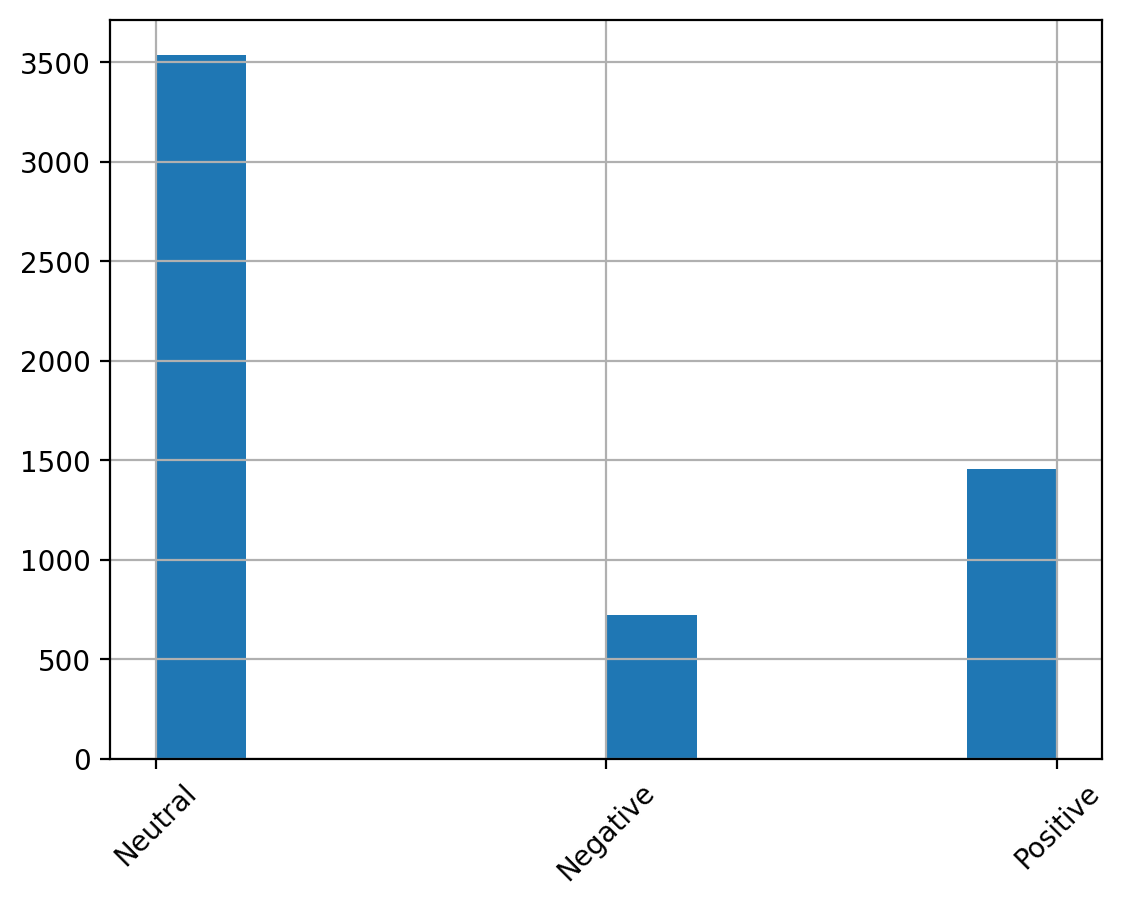

In [8]:
fig,ax = plt.subplots(1,1)

ax.hist(labels)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['Neutral','Negative','Positive'],rotation=45)
ax.grid()


To simplify the problem, we're fusing together *Neutral* and *Positive* labels. So label 1 is *Negative review* and label 0 is *Positive+Neutral*. Also, we separate between train, validation and test.

In [9]:
from sklearn.model_selection import train_test_split

labels_bin = labels.copy()
labels_bin[labels_bin==2] = 0
idx_data = np.arange(0,len(df),1)

# Separate train from test
idx_train, idx_test, y_train, y_test = train_test_split(idx_data, labels_bin, test_size=0.2, random_state=0)

# Separate train from val
idx_train, idx_val, y_train, y_val = train_test_split(idx_train, y_train, test_size=0.2, random_state=0)
acc_baseline_train = np.sum(y_train==0)/y_train.shape[0]

### Text pre-processing

With the following code, we pre-process using Spacy each sentence by removing words that are punctuation marks. We also remove [stopping words](https://nlp.stanford.edu/IR-book/html/htmledition/dropping-common-terms-stop-words-1.html) (words that are not very informative). As a result, we have the list `norm_docs`.

In [10]:
nlp = spacy.load("en_core_web_md") # Language model
docs = [nlp(c) for c in phrases]

# We remove punctuation marks (.,;:?!...) and stopping words
def normalize(doc):
    return [w for w in doc if w.has_vector and not w.is_punct and not w.is_stop]

norm_docs = [normalize(d) for d in docs]

Every item of `norm_docs` corresponds to each of the sentences in the dataset. Each item is itself a list of spacy tokens (basically words with different attributes). The most important attribute for us the the *word embedding vector*. For instance, lets print the first sentence

In [11]:
print(f'The first original sentence is: {phrases[0]}\n')
print(f'The first normalized sentence is: {norm_docs[0]}. The length of the document is {len(norm_docs[0])} tokens')

The first original sentence is: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .

The first normalized sentence is: [According, Gran, company, plans, production, Russia, company, growing]. The length of the document is 8 tokens


We can access to the word embedding of each token using the attribute `.vector`:

In [12]:
print(f'The word embedding associated with the token {norm_docs[0][0].text} is\n')
print(norm_docs[0][0].vector)

The word embedding associated with the token According is

[-7.2518e-01 -6.5831e+00  1.9781e+00  1.5750e+00  3.7848e+00 -7.7536e-01
  1.6243e+00  1.3813e+00 -7.4554e-01 -3.3811e+00  5.6047e-01  1.1629e+00
 -9.7465e-01  6.6956e-01  4.2558e-01  4.1766e+00  4.6478e+00  3.5616e+00
  7.3597e-01  3.6554e-01 -2.2610e+00 -4.1928e+00 -6.7455e-01  1.7693e+00
 -1.5665e-01 -1.1390e+00  1.8747e+00  2.9538e+00  5.5879e-01  3.0424e-01
  2.3027e-01  3.6405e-02  8.8395e-01  1.0494e+00 -1.7269e+00 -3.3406e-01
 -1.0464e+00 -9.8123e-01 -2.1267e+00 -2.9542e+00 -4.3075e+00 -1.5900e+00
 -8.9226e-01  3.6363e-01 -3.7703e+00 -1.8992e+00 -5.3433e-01  4.0256e+00
 -1.8628e+00 -1.9761e+00  1.2977e+00  3.6029e+00  1.6310e+00 -2.5195e+00
  2.0482e+00 -1.4805e+00 -1.4294e-01 -2.7591e+00 -3.4827e-01 -6.1484e+00
 -5.9045e-01 -5.3691e-01 -7.3631e-01  3.1585e+00  5.7914e+00 -1.1208e+00
 -2.5045e+00 -2.2957e+00  2.7173e+00  1.1104e+00  2.0943e+00 -2.6719e+00
 -2.6322e+00 -3.9377e+00 -1.3198e+00  3.5639e+00 -1.3974e+00  2.7

You can check that the word embedding dimension is 300 ...

In [13]:
print(f'The WE dimension is {norm_docs[0][0].vector.shape}')

The WE dimension is (300,)


### Length normalization

Note that in this problem we're working with sequences of text of different length. This is in principle not a problem for RNNs. However, there's one additional pre-processing step that we have to do. When we feed the RNN function **all sequences in the mini-batch must have the same length**. Then we will use the corresponding state to make the prediction.

For simplicity, we are taking here a non-efficient solution. Instead of normalize lengths at a batch level, we are normalizing the whole dataset so all sequences have the same length. To do so, we're adding **junk tokens** to all sentences so they artificially are of the same length. However, we will keep in a list the real length of each data, since the sentiment analysis prediction will be made using the RNN state corresponding to the **last real token**.



In [14]:
# List with the length for each sentence
lengths = [len(d) for d in norm_docs]

# Maximum length (in train!)
max_l = np.max([lengths[d] for d in idx_train])

In [15]:
# We add as many junk tokens (#) as needed to equalize the length of each sentence to max_l
garbage_token = nlp('#') # Junk token --> #

# We normalize the dataset
norm_docs_eq_length = [norm_docs[d]+[garbage_token]*(max_l-lengths[d]) for d in range(len(norm_docs))]

# Train documents
docs_train = [norm_docs_eq_length[d] for d in idx_train]
len_train = [lengths[d] for d in idx_train]

# Validation documents
docs_val = [norm_docs_eq_length[d] for d in idx_val]
len_val = [lengths[d] for d in idx_val]

# documentos test
docs_test = [norm_docs_eq_length[d] for d in idx_test]
len_test = [lengths[d] for d in idx_test]

Recall that for each document, the sequence of word embeddings is obtained using the `.vector` attribute per token ...

### RNN classification

Our goal is to implement an LSTM that takes as input the sequence of word embeddings and predicts the binary label. In the list `lengths` we have the length per document (before adding the junk tokens). The LSTM prediction **must be done using the LSTM state after processing the last real token**. That means we ignore the LSTM states after we start processing the junk tokens.


A few comments:

- The LSTM is trained using mini-batches. So the input is a tensor of dimension (batch_size, seq_length, max_l). You have to generate this tensor using the lists implemented before (`docs_train`, `docs_val`, `docs_test`).
- You don't care about the LSTM initializaiton. Use the default one.
- The LSTM provides the list of states upon processing the sequences of max_l word embeddings. For each sentence, you have to predict the label using the appropiate state (the one after processing the last real word). My advise is that you store in a list the decision states for each data in the minibatch and then concatenate them in a tensor using `torch.stack`.
- We will use a single MLP layer to perform the prediction. Between the LSTM and the MLP, we include a dropout layer.
- The network will take some time to train, so my advise is to save the network parameters after each epoch (in a separate file), so early stopping can be implemented without re-training.
- Validate the dimension of the LSTM state.

<img src='http://www.tsc.uc3m.es/~olmos/BBVA/RNN.png' width=800 />




In [16]:
from torch import nn
from torch import optim
import torch

>**Exercise:** Complete the following code to construct the RNN classifier

In [17]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers,prob=0.5):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.input_size = input_size

        # Define the LSTM layer
        self.rnn = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)

        # Fully-connected final layer
        self.fc1 = nn.Linear(hidden_dim, output_size)

        self.logsoftmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(p=prob)


    def forward(self, x, lengths, h0=None):
        '''
        - x: Sequences of word embeddings. Dimensions (batch_size, max_l, word_embedding_size)
        - lengths: The real length of each sequence, excluding the junk # tokens! You use this to know what
          RNN state you should use to classify
        '''

        batch_size = x.size(0)
        seq_length = x.size(1)

        # Compute the RNN output (sequence of states for the whole input)
        r_out, _ =  self.rnn(x)

        # Selecting the last valid output state for each sequence based on lengths
        last_outputs = torch.stack([r_out[i, lengths[i]-1] for i in range(batch_size)])

        # Applying dropout to the selected states
        last_outputs = self.dropout(last_outputs)

        # Passing through the fully connected layer
        output = self.fc1(last_outputs)

        # Applying LogSoftmax to get log-probabilities
        output = self.logsoftmax(output)

        return output

Let's first illustrate how we can get the output of the (untrained) RNN network given our texts. For example, let's get the RNN output for the first three training texts. The first step is to get the **sequences of word embeddings** of each of them...

In [18]:
idx = [1,2,3]
#[w.vector for w in docs_train[d]] generates the list of word vectors for the d-th document
x_input = torch.Tensor([[w.vector for w in docs_train[d]] for d in idx])

<ipython-input-18-31b6a0fc2f9f>:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  x_input = torch.Tensor([[w.vector for w in docs_train[d]] for d in idx])


In [19]:
d=1
np.array([docs_train[d][w].vector for w in range(len_train[d])]).shape

(14, 300)

In [20]:
aux = torch.Tensor([np.mean([docs_train[d][w].vector for w in range(len_train[d])],0) for d in idx])

The shape of `x_input` should be (3,max_l,300)

In [21]:
x_input.shape

torch.Size([3, 35, 300])

Let's instantiate the RNN class

In [22]:
my_RNN = RNN(300,2,20,1)

> **Exercise:** evaluate the RNN otuput for `x_input` and check that the ouput dimensions make sense

In [23]:
real_lengths = [lengths[d] for d in idx]
o = my_RNN.forward(x_input, real_lengths)

In [24]:
print(o)

tensor([[-0.3305, -1.2679],
        [-0.5284, -0.8904],
        [-0.6584, -0.7292]], grad_fn=<LogSoftmaxBackward0>)


In [25]:
o.shape

torch.Size([3, 2])

> **Exercise:** Complete the following class, which inherits the previous one and it adds a training loop, an evaluation method, and functionalities to save the model every few epochs

In [26]:
class RNN_with_train(RNN):

    def __init__(self,input_size, output_size, hidden_dim, n_layers,prob=0.0,batch_size=50,lr=0.0005,saved_files='./saved_models/RNN_sentiment_analysis'):

        super().__init__(input_size, output_size, hidden_dim, n_layers,prob)

        self.lr = lr # Learning Rate
        self.optim = optim.Adam(self.parameters(), self.lr) # Optimizer
        self.criterion = nn.NLLLoss()
        self.loss_during_training = []
        self.valid_loss_during_training = []
        self.batch_size = batch_size
        self.saved_files = saved_files


    def predict_proba(self,docs,lengths,Y=None):
        '''
        We use this method to get the output of the network given a set of documents. If label is provided,
        we get accuracy.

        - docs: documents, each encoded as a list of spacy tokens. They are length-normalized.
        - lengths: real length of each document.
        - Y: labels
        '''
        accuracy = 0.0
        with torch.no_grad():
            x_input = torch.Tensor([[w.vector for w in d] for d in docs])
            logprobs = self.forward(x_input, lengths).detach().numpy()

            if(len(Y)>0):
                accuracy = np.sum(np.argmax(logprobs,1)==Y)/np.shape(Y)[0]

        return logprobs,accuracy


    def fit(self,docs_train,docs_val,Y,Yval,len_train,len_val,epochs=100,print_every=5):
        '''
        Training method.

        - docs_train, docs_val: training/validation documents  (each is a list of spacy tokens).
          Normalized in length!
        - len_train/len_val: real lengths
        '''

        self.print_every = print_every
        self.epochs=epochs

        # Optimization Loop
        self.num_train = len(docs_train)
        self.num_batchs = np.floor(self.num_train/self.batch_size)
        self.num_val = len(docs_val)
        self.num_batchs_val = np.floor(self.num_val/self.batch_size)
        labels = torch.Tensor(Y).type(torch.LongTensor)
        labelsval = torch.Tensor(Yval).type(torch.LongTensor)

        for e in range(int(self.epochs)):
            self.train() # Activate dropout

            # Random data permutation
            idx = np.random.permutation(self.num_train)
            running_loss = 0.

            for i in range(int(self.num_batchs)):
                self.optim.zero_grad()

                # Indices of the data entering the batch
                idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]

                # Just in case there are empty documents, we ignore them
                idx_batch = [d for d in idx_batch if len_train[d]>0]

                # We code each document using the sequences of word embeddings
                x_input = torch.Tensor([[w.vector for w in docs_train[d]] for d in idx_batch])

                # We compute the classifier output for every data
                out = self.forward(x_input, [len_train[d] for d in idx_batch])

                # Cost function and gradient descent step
                loss = self.criterion(out,labels[idx_batch])
                running_loss += loss.item()
                loss.backward()

                # Gradient clipping
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)

                # SGD steps
                self.optim.step()

            self.loss_during_training.append(running_loss/self.num_batchs)

            # We save model parameters
            torch.save(self.state_dict(), self.saved_files+'_epoch_'+str(e)+'.pth')

            # We repeat for validation
            with torch.no_grad():
                # set model to evaluation mode
                self.eval()

                running_loss = 0.
                idx = np.random.permutation(self.num_val)

                for i in range(int(self.num_batchs_val)):
                    idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]

                    # Just in case there are empty documents, we ignore them
                    idx_batch = [d for d in idx_batch if len_val[d]>0]
                    x_input = torch.Tensor([[w.vector for w in docs_val[d]] for d in idx_batch])

                    out = self.forward(x_input,[len_val[d] for d in idx_batch])
                    loss = self.criterion(out,labelsval[idx_batch])
                    running_loss += loss.item()

                self.valid_loss_during_training.append(running_loss/self.num_batchs_val)

            if(e % self.print_every == 0):
                print(f"Training loss after {e} epochs: {self.loss_during_training[-1]}. Validation loss: {self.valid_loss_during_training[-1]}")

> **Exercise:** Instantiate and train the class using a hidden state of 20 dimensions and dropout probability equal to 0.3. Train for 40 epochs (can take a while)

In [27]:
my_RNN = RNN_with_train(300, 2, 20, 1, prob=0.3)

#Call train
my_RNN.fit(docs_train,docs_val,torch.Tensor(y_train),torch.Tensor(y_val),len_train,len_val,epochs=40,print_every=1)

Training loss after 0 epochs: 0.47017162711652993. Validation loss: 0.37039041850301957
Training loss after 1 epochs: 0.3645768018618022. Validation loss: 0.33142151683568954
Training loss after 2 epochs: 0.33180486359824873. Validation loss: 0.31385837992032367
Training loss after 3 epochs: 0.31765063392789394. Validation loss: 0.3044798548022906
Training loss after 4 epochs: 0.3008818265101681. Validation loss: 0.29415599670675063
Training loss after 5 epochs: 0.28540883774626746. Validation loss: 0.28555099417765933
Training loss after 6 epochs: 0.2716156242236699. Validation loss: 0.27998634841707015
Training loss after 7 epochs: 0.2553282825097646. Validation loss: 0.27173493512802654
Training loss after 8 epochs: 0.24928176933771942. Validation loss: 0.27207892802026534
Training loss after 9 epochs: 0.23301472749612104. Validation loss: 0.26244016074472004
Training loss after 10 epochs: 0.22216701497362085. Validation loss: 0.25713881270753014
Training loss after 11 epochs: 0.216

> **Exercise:** Plot both validation and training loss. Recover the model parameters for the epoch that minimized the validation loss. To do so, note that at every epoch the model parameters are save in a certain file named  `RNN_sentiment_analysis_epoch_X.pth` (unless you changed the default value), where `X` is the epoch. The function to re-state the parameters of the network are  `state_dict = my_RNN.load_state_dict(torch.load('RNN_sentiment_analysis_epoch_X.pth'))
`

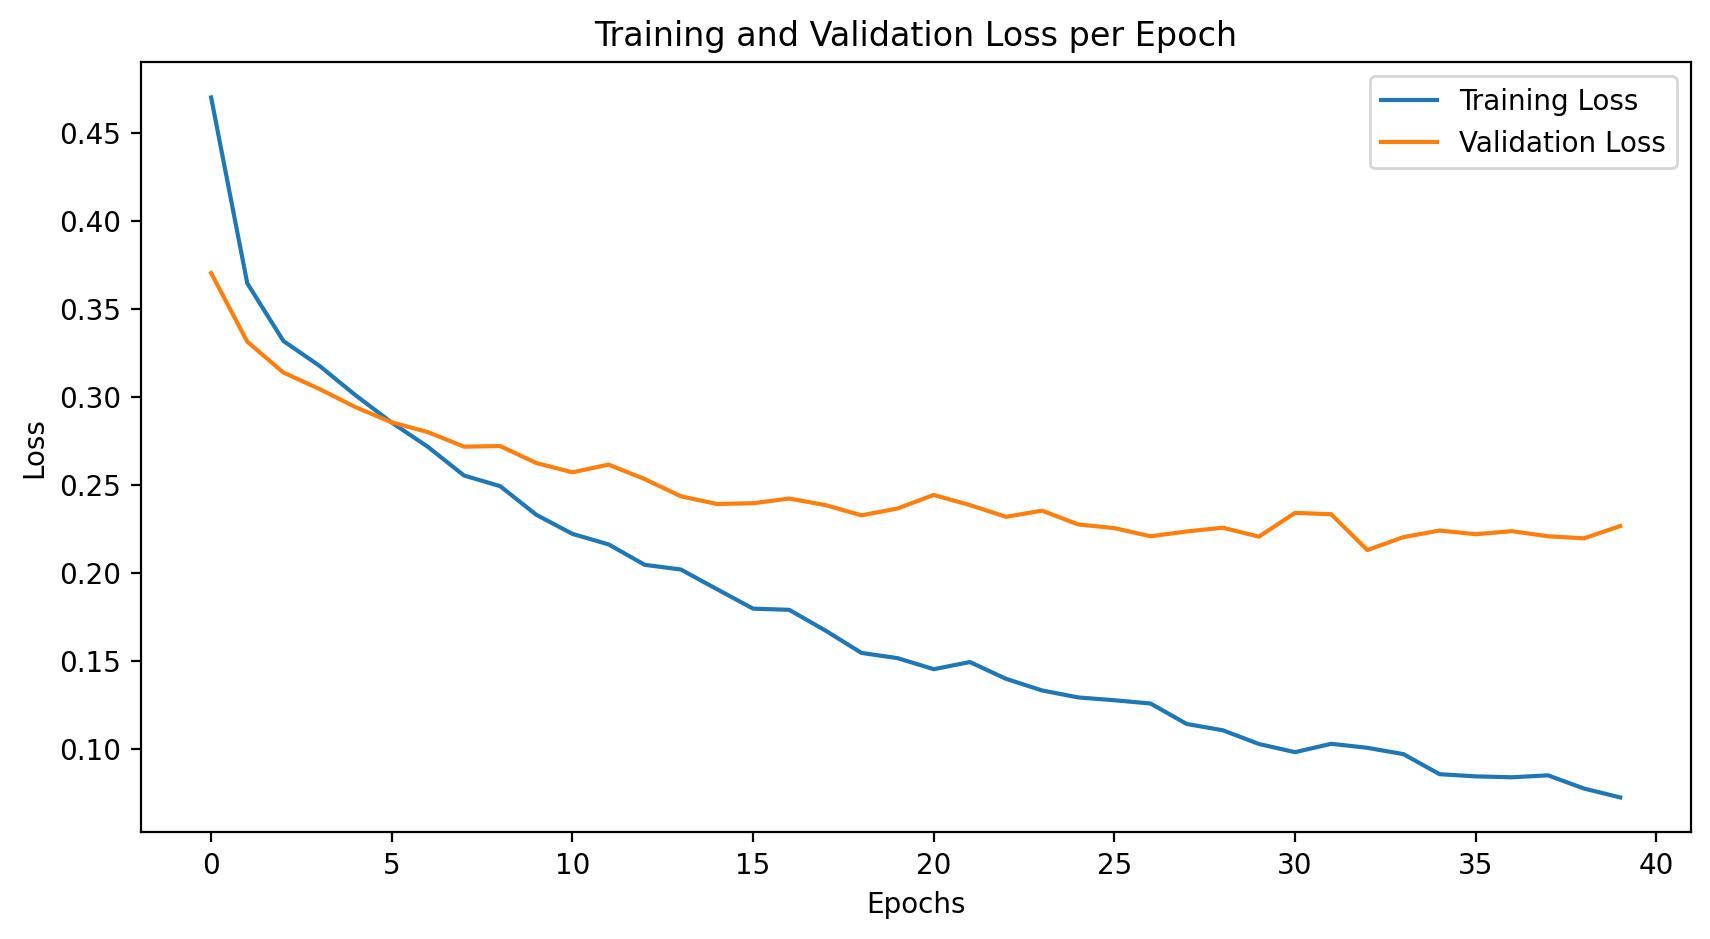

In [28]:
# Plotting the train/val loss
plt.figure(figsize=(10, 5))
plt.plot(my_RNN.loss_during_training, label='Training Loss')
plt.plot(my_RNN.valid_loss_during_training, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
# Recovering the best validation parameters
idx_sorted = np.argsort(my_RNN.valid_loss_during_training)
idx_min = idx_sorted[0]

best_model_path = f'{my_RNN.saved_files}_epoch_{str(idx_min)}.pth'
my_RNN.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

> **Exercise:** Using the method `predict_proba`, compute the accuracy and class probabilities for the data in the test set. Note that the method returns log-probabilities that you have to exponentiate.

In [30]:
logprobs, acc = my_RNN.predict_proba(docs_test, len_test, y_test)
probs = np.exp(logprobs)
print(f"The test accuracy is {acc}")

The test accuracy is 0.9361888111888111


The following code plots the ROC curve of the classifiers, and it computes the area under the curve:

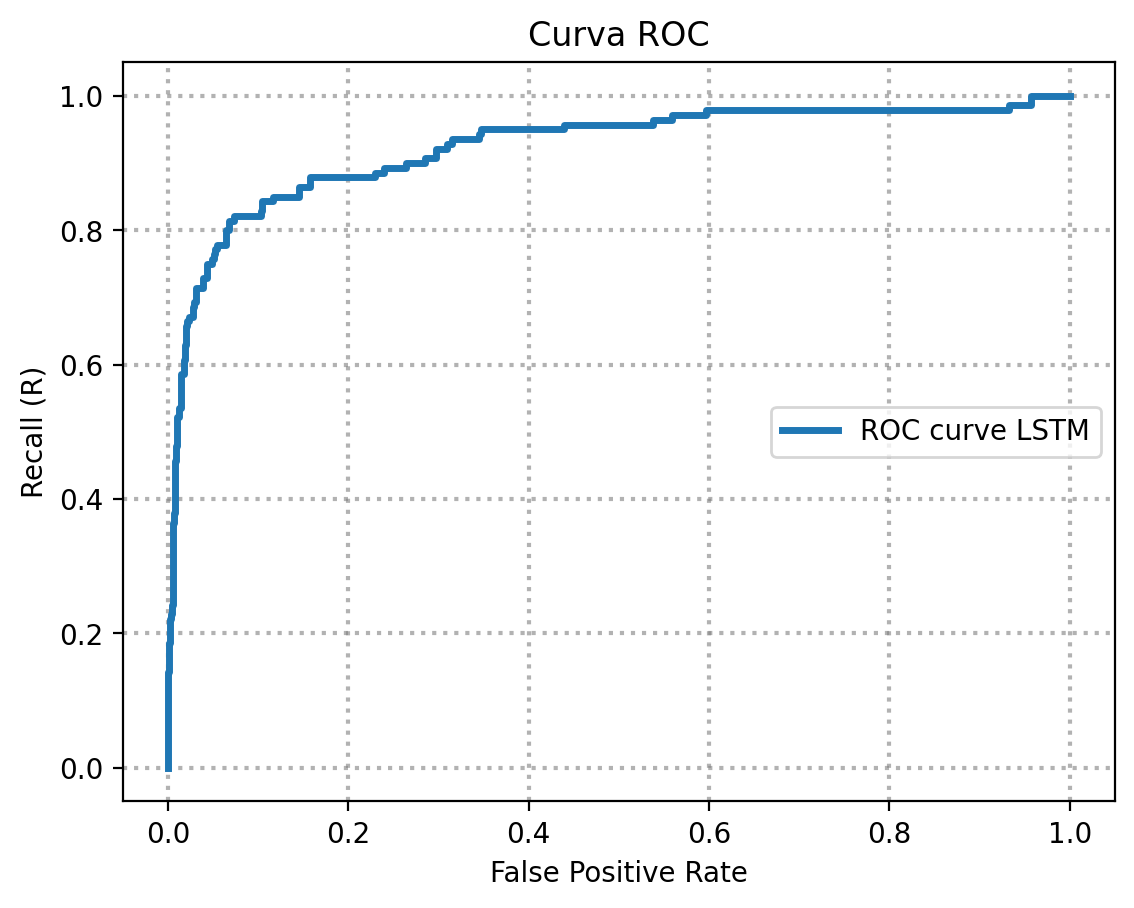

AUC ROC for LSTM is 0.924338360842345


In [31]:
from sklearn import metrics

fpr, recall, thresholds = metrics.roc_curve(y_test, probs[:,1], pos_label=1)

fig,ax = plt.subplots()
plt.plot(fpr,recall,lw=2.5,label='ROC curve LSTM')
plt.legend(loc=7)
plt.grid(which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc_LSTM = metrics.roc_auc_score(y_test, probs[:,1])

print(f"AUC ROC for LSTM is {area_roc_LSTM}")

If you do not implement the optimal part, just know that the proposed MLP solution AUC is typically less than 0.9

### (OPTIONAL)

Compare the accuracy/ROC with those achieved by the MLP classifier that predicts the label using the **mean of the word embeddings** (without junk tokens). Consider a three layer MLP with 10 and 5 hidden units respectively.


<img src='http://www.tsc.uc3m.es/~olmos/BBVA/MLP.png' width=800 />

In [39]:
import torch.nn.functional as F

# Define the MLP architecture
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [40]:
from torch.utils.data import TensorDataset, DataLoader

# Data preparation
X_train = np.array([np.mean([word.vector for word in doc], axis=0) for doc in docs_train])
X_val = np.array([np.mean([word.vector for word in doc], axis=0) for doc in docs_val])
X_test = np.array([np.mean([word.vector for word in doc], axis=0) for doc in docs_test])

# Convert the datasets into tensor datasets then to dataloaders
train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_data = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_data = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(train_data, shuffle=True, batch_size=50)
val_loader = DataLoader(val_data, shuffle=True, batch_size=50)
test_loader = DataLoader(test_data, shuffle=False, batch_size=50)

In [41]:
# Function that will be used to calculate the accuracy of the MLP
def calculate_accuracy(model, data_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in data_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = correct / total
    return accuracy

In [42]:
# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=25):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        val_loss = 0.0
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

        train_accuracy = calculate_accuracy(model, train_loader)
        val_accuracy = calculate_accuracy(model, val_loader)

        print(f'Epoch {epoch+1}/{epochs}.. '
              f'Train loss: {running_loss/len(train_loader):.3f}.. '
              f'Validation loss: {val_loss/len(val_loader):.3f}.. '
              f'Train accuracy: {train_accuracy:.3f}.. '
              f'Validation accuracy: {val_accuracy:.3f}')

        # Save the model if the validation loss decreases
        if epoch == 0 or val_loss < min_val_loss:
            print(f'Validation loss decreased. Saving model ...')
            torch.save(model.state_dict(), 'mlp_sentiment_model.pth')
            min_val_loss = val_loss

In [43]:
# Instantiate the model
mlp_model = MLP(input_size=300, hidden_size1=10, hidden_size2=5, output_size=2)

# Loss function and optimizer to train the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
train_model(mlp_model, train_loader, val_loader, criterion, optimizer, epochs=40)

Epoch 1/40.. Train loss: 0.591.. Validation loss: 0.468.. Train accuracy: 0.870.. Validation accuracy: 0.884
Validation loss decreased. Saving model ...
Epoch 2/40.. Train loss: 0.514.. Validation loss: 0.411.. Train accuracy: 0.870.. Validation accuracy: 0.884
Validation loss decreased. Saving model ...
Epoch 3/40.. Train loss: 0.478.. Validation loss: 0.412.. Train accuracy: 0.870.. Validation accuracy: 0.884
Epoch 4/40.. Train loss: 0.462.. Validation loss: 0.405.. Train accuracy: 0.870.. Validation accuracy: 0.884
Validation loss decreased. Saving model ...
Epoch 5/40.. Train loss: 0.451.. Validation loss: 0.397.. Train accuracy: 0.870.. Validation accuracy: 0.884
Validation loss decreased. Saving model ...
Epoch 6/40.. Train loss: 0.428.. Validation loss: 0.377.. Train accuracy: 0.870.. Validation accuracy: 0.884
Validation loss decreased. Saving model ...
Epoch 7/40.. Train loss: 0.418.. Validation loss: 0.364.. Train accuracy: 0.870.. Validation accuracy: 0.884
Validation loss d

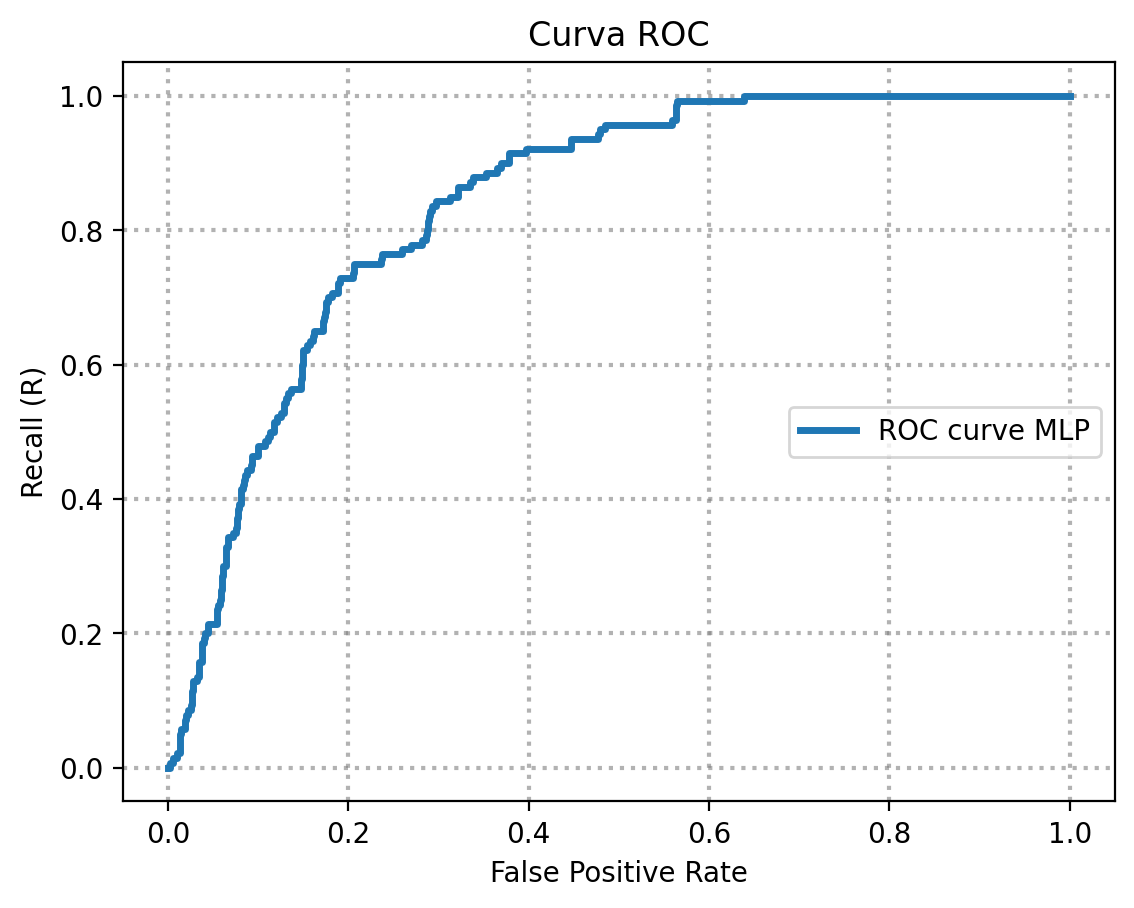

AUC ROC for MLP is 0.8385813887307911


In [44]:
accuracy = calculate_accuracy(mlp_model, test_loader)

# Calculate ROC AUC
probs = torch.softmax(mlp_model(torch.from_numpy(X_test).float()), dim=1)
fpr, recall, thresholds = metrics.roc_curve(y_test, probs[:, 1].detach().numpy(), pos_label=1)
roc_auc = metrics.auc(fpr, recall)

fig,ax = plt.subplots()
plt.plot(fpr,recall,lw=2.5,label='ROC curve MLP')
plt.legend(loc=7)
plt.grid(which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc_LSTM = metrics.roc_auc_score(y_test, probs[:,1].detach().numpy())

print(f"AUC ROC for MLP is {area_roc_LSTM}")

In this section we will look at the differences between the two models seen so far.

MLP Test Accuracy: 0.8776223776223776
RNN Test Accuracy: 0.9361888111888111
MLP ROC AUC: 0.8385813887307911
RNN ROC AUC: 0.924338360842345


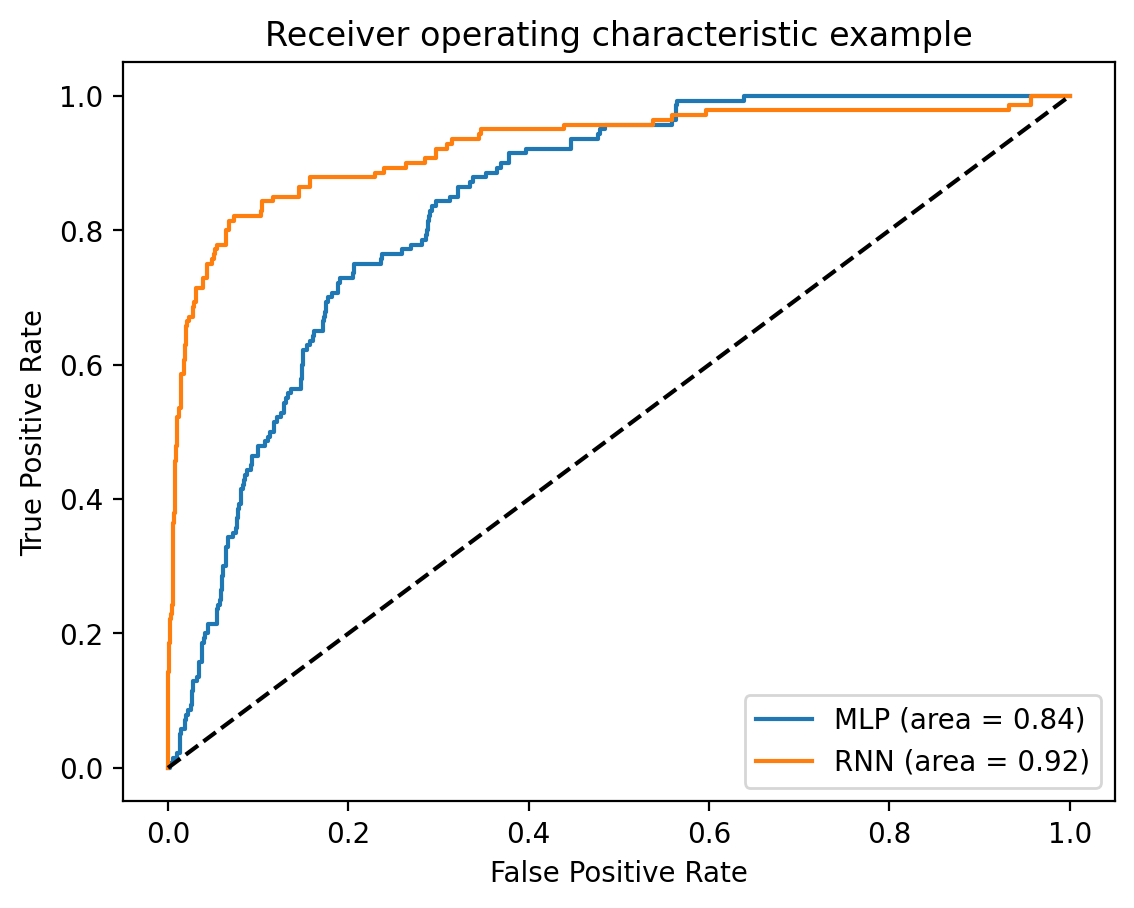

In [45]:
mlp_accuracy = calculate_accuracy(mlp_model, test_loader)
logprobs, rnn_accuracy = my_RNN.predict_proba(docs_test, len_test, y_test)

print(f"MLP Test Accuracy: {mlp_accuracy}")
print(f"RNN Test Accuracy: {rnn_accuracy}")

# Calculate ROC AUC for MLP
mlp_probs = torch.softmax(mlp_model(torch.from_numpy(X_test).float()), dim=1)
mlp_fpr, mlp_tpr, _ = metrics.roc_curve(y_test, mlp_probs[:, 1].detach().numpy(), pos_label=1)
mlp_roc_auc = metrics.auc(mlp_fpr, mlp_tpr)

# Calculate ROC AUC for RNN
rnn_probs = np.exp(logprobs)
rnn_fpr, rnn_tpr, _ = metrics.roc_curve(y_test, rnn_probs[:, 1], pos_label=1)
rnn_roc_auc = metrics.auc(rnn_fpr, rnn_tpr)

print(f"MLP ROC AUC: {mlp_roc_auc}")
print(f"RNN ROC AUC: {rnn_roc_auc}")

# Plot ROC curves
plt.figure()
plt.plot(mlp_fpr, mlp_tpr, label='MLP (area = %0.2f)' % mlp_roc_auc)
plt.plot(rnn_fpr, rnn_tpr, label='RNN (area = %0.2f)' % rnn_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Lab: RNNs for Sentiment Analysis (with Attention)


------------------------------------------------------

*Pablo M. Olmos pamartin@ing.uc3m.es*


------------------------------------------------------

In this notebook your goal is to take your solution to the previous Lab (Sentiment Analysis with RNNs) and add a simple attention layer before the classifier. Let $\mathbf{h}_0,\ldots,\mathbf{h}_\ell$ be the RNN output states ($\ell$ is the last state before feeding the garbage tokens):
- We will use $\mathbf{h}_\ell$ as the query ($\mathbf{q}=\mathbf{h}_\ell$)
- $\mathbf{h}_0,\ldots,\mathbf{h}_\ell$ are the keys
- Construct a two-layer MLP to construct the unnormalized weights $w_j=a(\mathbf{q},\mathbf{h}_j)$, $j=1,\ldots,\ell$. For the intermediate layer, use $tanh()$ activation.
- Normalized weights are given by $\mathbf{\alpha}=\text{Softmax}(w_1,\ldots,w_\ell)$.
- Input to the classifier is
\begin{align}
\mathbf{c} = \sum_{j=1}^{\ell}\alpha_j \mathbf{h}_j
\end{align}

Analyze if performance is improved and visualize the attention weights for a couple of cases.

**Note:** While you do not have to code much more given the solution of the previous lab, it is tricky to code the attention layer efficiently.

**Note 2:** Note we do NOT include in the attention module the states corresponding to processing the garbage token # to normalize lengths. It's important to keep this in mind. You can do this by masking the unnormalized weights $w_j$ if you compute then for the whole RNN output sequence.

In [46]:
with open("Sentences.txt", "r", encoding="ISO-8859-1") as sentences:
    lines = sentences.readlines()

We split the sentence and we code with 0 neutral labels, with 1 negative labels, and with 2 positive labels

In [47]:
phrases = [l.split('@')[0] for l in lines]
opinions = [l.split('@')[1] for l in lines]

def code_opinion(l):
    d = 0
    if (l=='negative\n'):
        d = 1
    elif (l=='positive\n'):
        d = 2

    return d

labels = np.array([code_opinion(l) for l in opinions])

In [48]:
df = pd.DataFrame({"Phrase":phrases,
                  "Opinion":opinions})
df

,Phrase,Opinion
0,"According to Gran , the company has no plans t...",neutral\n
1,With the new production plant the company woul...,positive\n
2,"For the last quarter of 2010 , Componenta 's n...",positive\n
3,"In the third quarter of 2010 , net sales incre...",positive\n
4,Operating profit rose to EUR 13.1 mn from EUR ...,positive\n
...,...,...
5712,Operating result for the 12-month period decre...,negative\n
5713,HELSINKI Thomson Financial - Shares in Cargote...,negative\n
5714,LONDON MarketWatch -- Share prices ended lower...,negative\n
5715,Operating profit fell to EUR 35.4 mn from EUR ...,negative\n


To simplify the problem, we're fusing together *Neutral* and *Positive* labels. So label 1 is *Negative review* and label 0 is *Positive+Neutral*. Also, we separate between train, validation and test.

In [49]:
labels_bin = labels.copy()
labels_bin[labels_bin==2] = 0
idx_data = np.arange(0,len(df),1)

# Separamos train de test
idx_train, idx_test, y_train_attention, y_test_attention = train_test_split(idx_data, labels_bin, test_size=0.2, random_state=0)

# Separamos train de val
idx_train, idx_val, y_train_attention, y_val_attention = train_test_split(idx_train, y_train_attention, test_size=0.2, random_state=0)
acc_baseline_train = np.sum(y_train_attention==0)/y_train_attention.shape[0]

### Text pre-processing

We are repeating the steps we took for the case of the first RNN but with new variable names and new data, in order to keep the previous ones and have new ones. This will allow us later to compare the 3 models seen in this practice and to analyze the results of each one and the comparison between them.

In [50]:
nlp = spacy.load("en_core_web_md") # Language model
docs = [nlp(c) for c in phrases]

# We remove punctuation marks (.,;:?!...) and stopping words
def normalize(doc):
    return [w for w in doc if w.has_vector and not w.is_punct and not w.is_stop]

norm_docs = [normalize(d) for d in docs]

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


### Length normalization

In [51]:
# List with the length for each sentence
lengths = [len(d) for d in norm_docs]

# Maximum length (in train!)
max_l = np.max([lengths[d] for d in idx_train])

In [52]:
# We add as many junk tokens (#) as needed to equalize the length of each sentence to max_l
garbage_token = nlp('#') # Junk token --> #

# We normalize the dataset
norm_docs_eq_length = [norm_docs[d]+[garbage_token]*(max_l-lengths[d]) for d in range(len(norm_docs))]

# Train documents
docs_train_attention = [norm_docs_eq_length[d] for d in idx_train]
len_train_attention = [lengths[d] for d in idx_train]

# Validation documents
docs_val_attention = [norm_docs_eq_length[d] for d in idx_val]
len_val_attention = [lengths[d] for d in idx_val]

# documentos test
docs_test_attention = [norm_docs_eq_length[d] for d in idx_test]
len_test_attention = [lengths[d] for d in idx_test]

In [53]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.hidden_dim = hidden_dim
        self.attention_fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.attention_fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, rnn_output, lengths):

        # Apply two-layer MLP (with tanh activation for the first layer)
        attn_weights = self.attention_fc1(rnn_output)
        attn_weights = torch.tanh(attn_weights)
        attn_weights = self.attention_fc2(attn_weights)

        # Masking for excluding garbage tokens
        for i, length in enumerate(lengths):
            attn_weights[i, length:] = -1e10  # Masked positions are given a large negative value

        # Softmax to get normalized weights
        attn_weights = F.softmax(attn_weights.squeeze(2), dim=1)

        # Multiply each vector by its softmax weight (batched matrix multiply)
        weighted_rnn_output = rnn_output * attn_weights.unsqueeze(2)
        # Sum over the time dimension to get the context vector
        context_vector = weighted_rnn_output.sum(dim=1)

        return context_vector, attn_weights

In [54]:
class RNN_with_Attention(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size, n_layers):
        super(RNN_with_Attention, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)
        self.attention_layer = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, lengths):
        rnn_output, _ = self.rnn(x)  # Get the RNN output for the whole sequence
        context_vector, attn_weights = self.attention_layer(rnn_output, lengths)
        output = self.fc(context_vector)
        output = self.logsoftmax(output)
        return output


In [55]:
class RNN_with_Attention_and_Train(RNN_with_Attention):
    def __init__(self,input_size, output_size, hidden_dim, n_layers,dropout_prob=0.0,batch_size=50,lr=0.0005,saved_files='./saved_models/RNN_sentiment_analysis_attention'):
        super().__init__(input_size, output_size, hidden_dim, n_layers)

        self.dropout = nn.Dropout(dropout_prob)  # Dropout layer

        # Add dropout to the layers
        for layer in [self.rnn, self.attention_layer, self.fc]:
            if hasattr(layer, 'weight'):
                layer.weight.requires_grad = True  # Ensure weights require gradients
            layer = nn.Sequential(layer, self.dropout)

        self.lr = lr # Learning Rate
        self.optim = optim.Adam(self.parameters(), self.lr) # Optimizer
        self.criterion = nn.NLLLoss()
        self.loss_during_training = []
        self.valid_loss_during_training = []
        self.batch_size = batch_size
        self.saved_files = saved_files


    def predict_proba(self,docs,lengths,Y=None):
        accuracy = 0.0
        with torch.no_grad():
            x_input = torch.Tensor([[w.vector for w in d] for d in docs])
            logprobs = self.forward(x_input, lengths).detach().numpy()

            if(len(Y)>0):
                accuracy = np.sum(np.argmax(logprobs,1)==Y)/np.shape(Y)[0]

        return logprobs,accuracy


    def fit(self,docs_train,docs_val,Y,Yval,len_train,len_val,epochs=100,print_every=5):
        self.print_every = print_every
        self.epochs=epochs

        # Optimization Loop
        self.num_train = len(docs_train)
        self.num_batchs = np.floor(self.num_train/self.batch_size)
        self.num_val = len(docs_val)
        self.num_batchs_val = np.floor(self.num_val/self.batch_size)
        labels = torch.Tensor(Y).type(torch.LongTensor)
        labelsval = torch.Tensor(Yval).type(torch.LongTensor)

        for e in range(int(self.epochs)):
            self.train() # Activate dropout

            # Random data permutation
            idx = np.random.permutation(self.num_train)
            running_loss = 0.

            for i in range(int(self.num_batchs)):
                self.optim.zero_grad()

                # Indices of the data entering the batch
                idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]

                # Just in case there are empty documents, we ignore them
                idx_batch = [d for d in idx_batch if len_train[d]>0]

                # We code each document using the sequences of word embeddings
                x_input = torch.Tensor([[w.vector for w in docs_train[d]] for d in idx_batch])

                # We compute the classifier output for every data
                out = self.forward(x_input, [len_train[d] for d in idx_batch])

                # Cost function and gradient descent step
                loss = self.criterion(out,labels[idx_batch])
                running_loss += loss.item()
                loss.backward()

                # Gradient clipping
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)

                # SGD steps
                self.optim.step()

            self.loss_during_training.append(running_loss/self.num_batchs)

            # We save model parameters
            torch.save(self.state_dict(), self.saved_files+'_epoch_'+str(e)+'.pth')

            # We repeat for validation
            with torch.no_grad():
                # set model to evaluation mode
                self.eval()

                running_loss = 0.
                idx = np.random.permutation(self.num_val)

                for i in range(int(self.num_batchs_val)):
                    idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]

                    # Just in case there are empty documents, we ignore them
                    idx_batch = [d for d in idx_batch if len_val[d]>0]
                    x_input = torch.Tensor([[w.vector for w in docs_val[d]] for d in idx_batch])

                    out = self.forward(x_input,[len_val[d] for d in idx_batch])
                    loss = self.criterion(out,labelsval[idx_batch])
                    running_loss += loss.item()

                self.valid_loss_during_training.append(running_loss/self.num_batchs_val)

            if(e % self.print_every == 0):
                print(f"Training loss after {e} epochs: {self.loss_during_training[-1]}. Validation loss: {self.valid_loss_during_training[-1]}")

We instantiate and train the model

In [56]:
my_RNN_with_Attention = RNN_with_Attention_and_Train(input_size=300, output_size=20, hidden_dim=2, n_layers=1, dropout_prob=0.3)

#Call train
my_RNN_with_Attention.fit(docs_train_attention, docs_val_attention, torch.Tensor(y_train_attention),torch.Tensor(y_val_attention),len_train_attention,len_val_attention,epochs=40,print_every=1)

Training loss after 0 epochs: 0.48579880554382115. Validation loss: 0.3373211936818229
Training loss after 1 epochs: 0.338094368781129. Validation loss: 0.3040738304456075
Training loss after 2 epochs: 0.305206955091594. Validation loss: 0.28788500113619697
Training loss after 3 epochs: 0.2777608533019889. Validation loss: 0.26688018606768715
Training loss after 4 epochs: 0.2506024483336161. Validation loss: 0.2440542752544085
Training loss after 5 epochs: 0.2199635504655642. Validation loss: 0.22664372871319452
Training loss after 6 epochs: 0.19151161560048796. Validation loss: 0.21416418006022772
Training loss after 7 epochs: 0.16614859663460352. Validation loss: 0.2001906012495359
Training loss after 8 epochs: 0.14300130338293232. Validation loss: 0.18777920388513142
Training loss after 9 epochs: 0.12587226462894924. Validation loss: 0.17775853474934897
Training loss after 10 epochs: 0.10974033074836208. Validation loss: 0.17732985524667633
Training loss after 11 epochs: 0.095638225

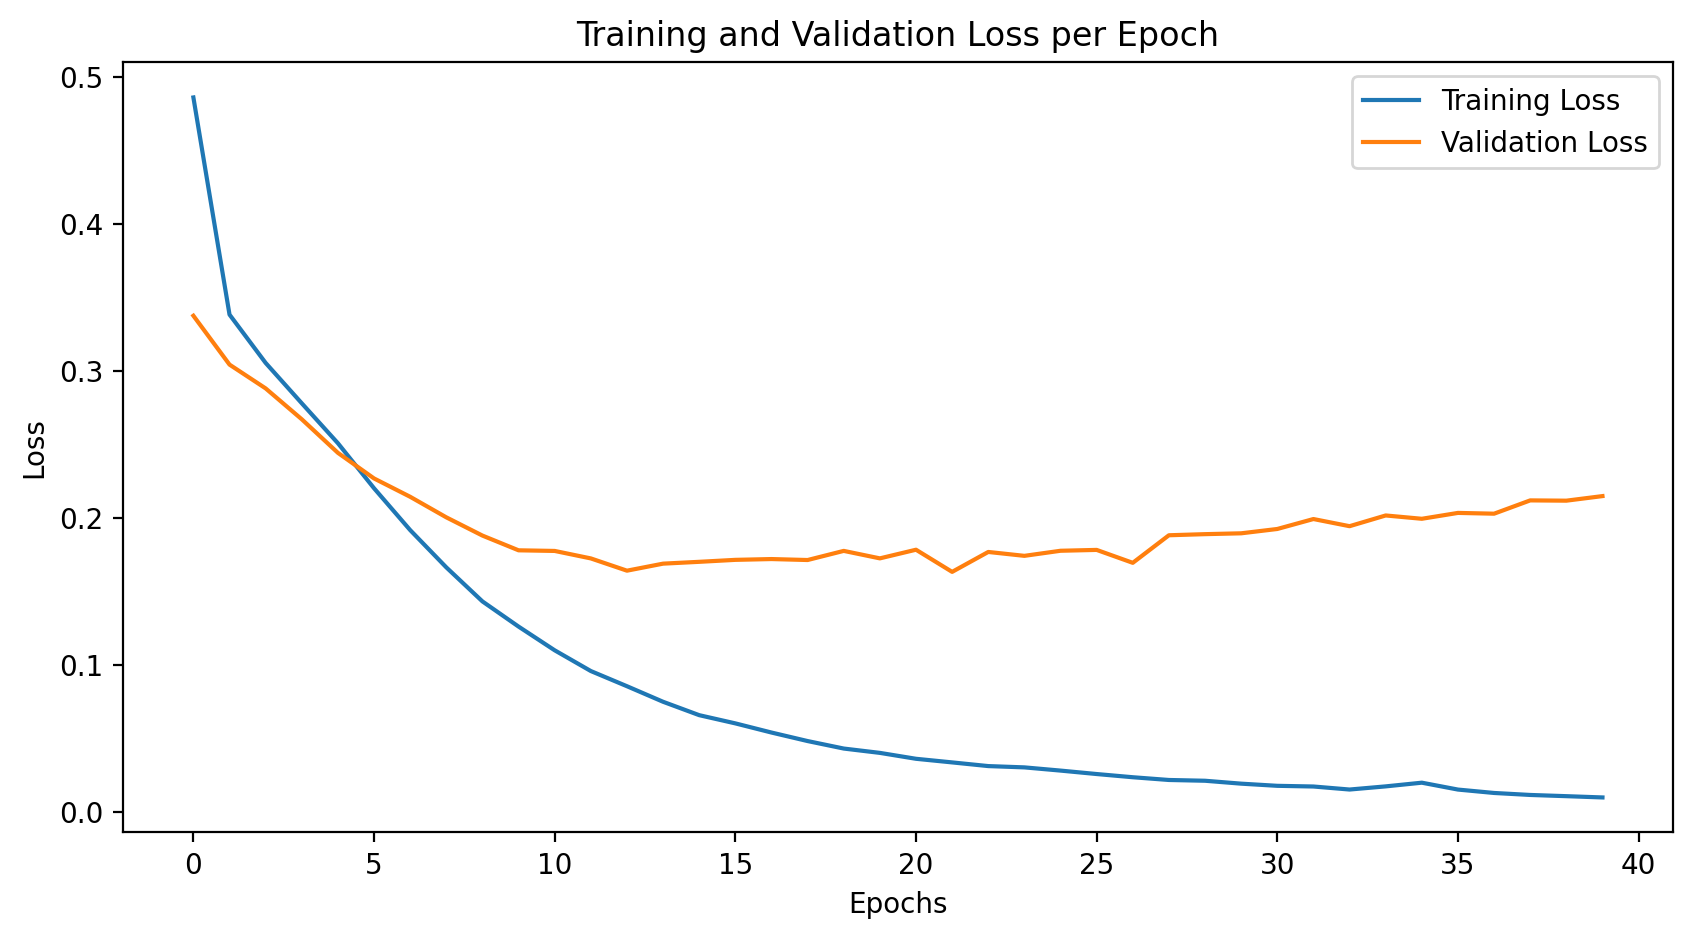

In [57]:
# Plotting the train/val loss
plt.figure(figsize=(10, 5))
plt.plot(my_RNN_with_Attention.loss_during_training, label='Training Loss')
plt.plot(my_RNN_with_Attention.valid_loss_during_training, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [58]:
# Recovering the best validation parameters
idx_sorted = np.argsort(my_RNN_with_Attention.valid_loss_during_training)
idx_min = idx_sorted[0]

best_model_path = f'{my_RNN_with_Attention.saved_files}_epoch_{str(idx_min)}.pth'
my_RNN_with_Attention.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [59]:
logprobs_attention, acc_attention = my_RNN_with_Attention.predict_proba(docs_test_attention, len_test_attention, y_test)
probs_attention = np.exp(logprobs_attention)
print(f"The test accuracy is {acc_attention}")

The test accuracy is 0.9554195804195804


We calculate the accuracy and the ROC curve

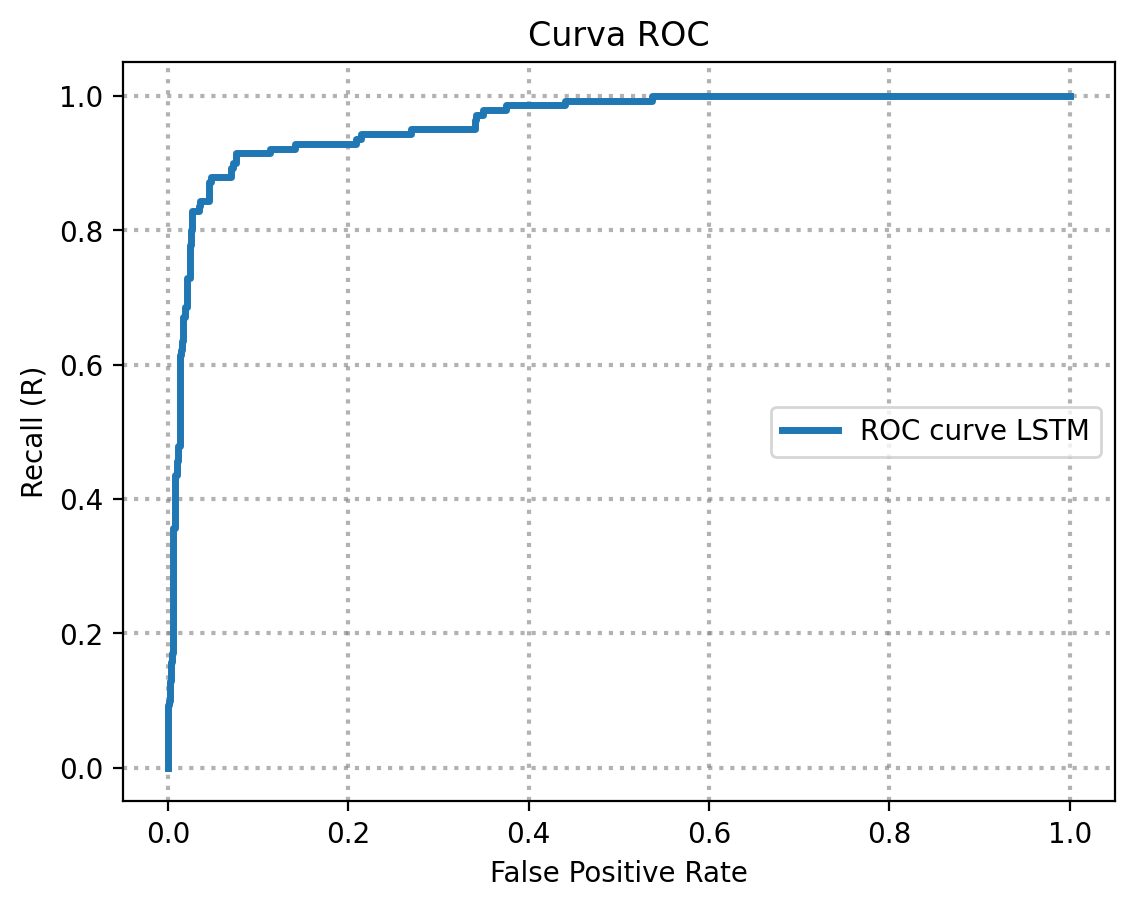

AUC ROC for RNN with Attention is 0.9603941377347751


In [60]:
fpr_attention, recall_attention, thresholds_attention = metrics.roc_curve(y_test_attention, probs_attention[:,1], pos_label=1)

fig,ax = plt.subplots()
plt.plot(fpr_attention,recall_attention,lw=2.5,label='ROC curve LSTM')
plt.legend(loc=7)
plt.grid(which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc_LSTM_attention = metrics.roc_auc_score(y_test_attention, probs_attention[:,1])
print(f"AUC ROC for RNN with Attention is {area_roc_LSTM_attention}")

Finally, we compare the 3 models trained and seen during this practice.

MLP Test Accuracy: 0.8776223776223776
RNN Test Accuracy: 0.9361888111888111
RNN With Attention Test Accuracy: 0.9554195804195804
MLP ROC AUC: 0.8385813887307911
RNN ROC AUC: 0.924338360842345
RNN Attention ROC AUC: 0.9603941377347751


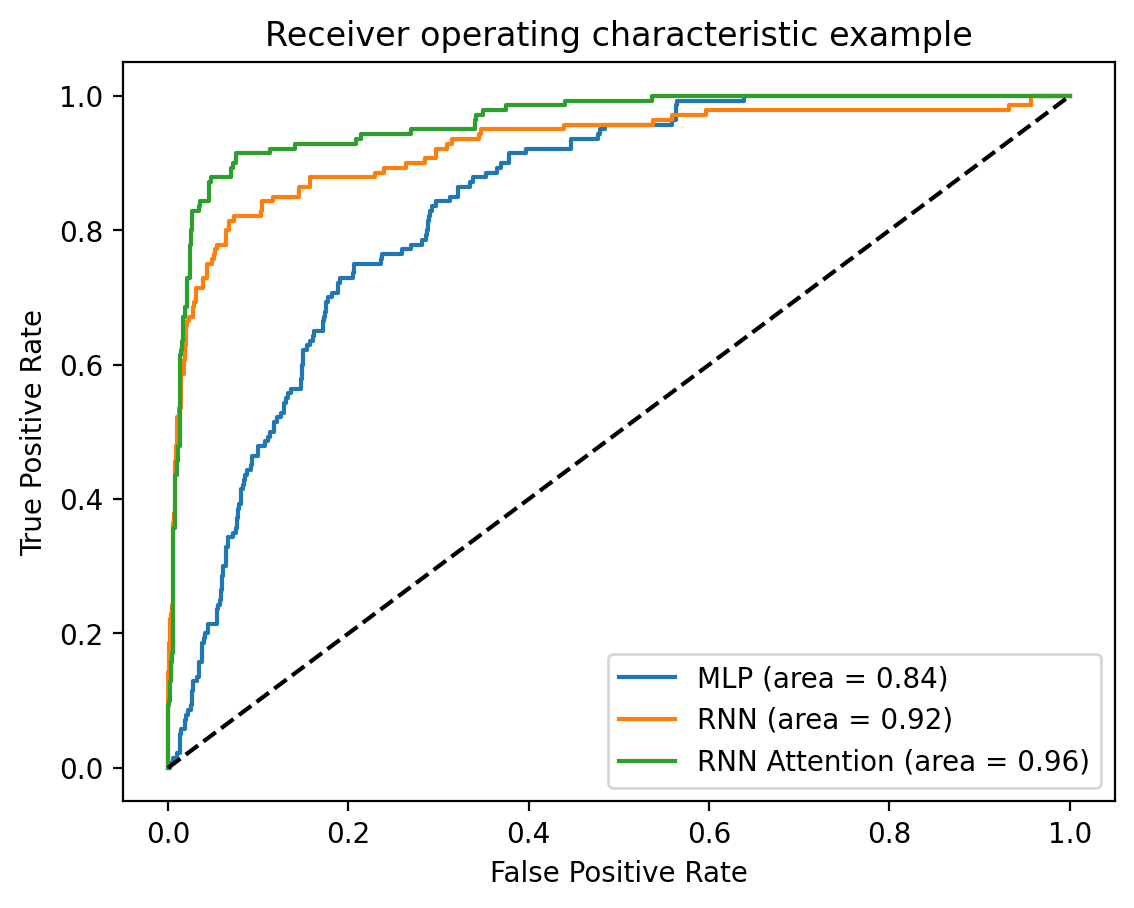

In [62]:
mlp_accuracy = calculate_accuracy(mlp_model, test_loader)
logprobs, rnn_accuracy = my_RNN.predict_proba(docs_test, len_test, y_test)
logprobs_attention, rnn_attention_accuracy = my_RNN_with_Attention.predict_proba(docs_test_attention, len_test_attention, y_test_attention)

print(f"MLP Test Accuracy: {mlp_accuracy}")
print(f"RNN Test Accuracy: {rnn_accuracy}")
print(f"RNN With Attention Test Accuracy: {rnn_attention_accuracy}")

# Calculate ROC AUC for MLP
mlp_probs = torch.softmax(mlp_model(torch.from_numpy(X_test).float()), dim=1)
mlp_fpr, mlp_tpr, _ = metrics.roc_curve(y_test, mlp_probs[:, 1].detach().numpy(), pos_label=1)
mlp_roc_auc = metrics.auc(mlp_fpr, mlp_tpr)

# Calculate ROC AUC for RNN
rnn_probs = np.exp(logprobs)
rnn_fpr, rnn_tpr, _ = metrics.roc_curve(y_test, rnn_probs[:, 1], pos_label=1)
rnn_roc_auc = metrics.auc(rnn_fpr, rnn_tpr)

# Calculate ROC AUC for RNN with Attention
rnn_attention_probs = np.exp(logprobs_attention)
rnn_attention_fpr, rnn_attention_tpr, _ = metrics.roc_curve(y_test_attention, rnn_attention_probs[:, 1], pos_label=1)
rnn_attention_roc_auc = metrics.auc(rnn_attention_fpr, rnn_attention_tpr)

print(f"MLP ROC AUC: {mlp_roc_auc}")
print(f"RNN ROC AUC: {rnn_roc_auc}")
print(f"RNN Attention ROC AUC: {rnn_attention_roc_auc}")

# Plot ROC curves
plt.figure()
plt.plot(mlp_fpr, mlp_tpr, label='MLP (area = %0.2f)' % mlp_roc_auc)
plt.plot(rnn_fpr, rnn_tpr, label='RNN (area = %0.2f)' % rnn_roc_auc)
plt.plot(rnn_attention_fpr, rnn_attention_tpr, label='RNN Attention (area = %0.2f)' % rnn_attention_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()